In [1]:
import gpflow
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp
from scipy.integrate import solve_ivp, odeint
from gpflow.utilities import print_summary, positive, to_default_float, set_trainable
from invariance_kernels import ZeroMean, get_MOI, get_damped_SHM_invariance, get_damped_pendulum_invariance
from invariance_functions import degree_of_freedom, get_GPR_model, get_SHM_data, get_pendulum_data, get_grid_of_points_1D, evaluate_model_future, evaluate_model_grid, damped_SHM_dynamics,damped_pendulum_dynamics
from parameterised_invariance_kernels import get_damped_polynomial_invariance
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '4'

In [2]:
mean = ZeroMean(2)
time_step = 0.01
training_time = 0.1
testing_time =  3

max_x = 150  
n_train = 3 
train_starting_position = np.random.uniform(-max_x, max_x, (n_train))
train_starting_velocity = np.random.uniform(-max_x/5, max_x/5, (n_train))

print(train_starting_position)
print(train_starting_velocity)
data = get_damped_pendulum_data(0.1, time_step, training_time, 1e-8, train_starting_position, train_starting_velocity) #switch

[ 4.71131938 62.06837861 66.82955661]
[ 16.69190666  -7.86642643 -27.76118599]


In [8]:
jitter = 5e-6
invar_density = 20
moi = get_GPR_model(get_MOI(), mean, data, 500)
print("moi: %s"%moi.log_marginal_likelihood().numpy())
kernel = get_damped_pendulum_invariance(3, invar_density, jitter) #switch
known = get_GPR_model(kernel, mean, data, 500)
print("known: %s"%known.log_marginal_likelihood().numpy())
latex = ""
try:
    for poly_f_d in [3]:
        for poly_g_d in [4]:
            kernel = get_damped_polynomial_invariance(3, invar_density, jitter, poly_f_d, poly_g_d) #switch
            m = get_GPR_model(kernel, mean, data, 500)
            print("(%s, %s)----------------------"%(poly_f_d, poly_g_d))
            print(kernel.f_poly.numpy())
            print(kernel.g_poly.numpy())
            print(format(m.log_marginal_likelihood().numpy(),".2f"))
            latex+=format(m.log_marginal_likelihood().numpy(),".2f")
            latex+="&"
except tf.errors.InvalidArgumentError:
    print("jitter too small")

moi: 234.99257828666504
known: 265.4082403761704
(3, 4)----------------------
[[-0.00169809]
 [ 1.        ]
 [-0.01769695]]
[[-0.0010726 ]
 [ 1.        ]
 [ 0.00133142]
 [-0.14882311]]
257.59


In [6]:
latex

'234.11&203.26&203.05&199.71&234.03&243.55&249.73&nan&220.67&206.17&250.61&256.79&236.49&225.86&253.86&nan&'

In [28]:
lml_moi = []
lml_inv = []
lml_inv_p = []
eva_future_moi = []
eva_future_inv = []
eva_future_inv_p = []
eva_grid_moi = []
eva_grid_inv = []
eva_grid_inv_p = []
for i in range(1):
    test_starting_position = np.radians((np.random.uniform(-max_x,max_x)))
    test_starting_velocity = np.radians((np.random.uniform(-max_x/5, max_x/5)))
    testing_time = 6

    print(test_starting_position)
    print(test_starting_velocity)

    evaluate_moi = evaluate_model_future(moi, test_starting_position, test_starting_velocity, damped_pendulum_dynamics, testing_time, time_step)
    lml_moi.append(moi.log_marginal_likelihood().numpy())
    eva_future_moi.append(evaluate_moi[0])
    eva_grid_moi.append(evaluate_model_grid(moi, np.radians(150), 40,damped_pendulum_dynamics))

    evaluate_invariance = evaluate_model_future(known, test_starting_position, test_starting_velocity, damped_pendulum_dynamics, testing_time, time_step)
    lml_inv.append(known.log_marginal_likelihood().numpy())
    eva_future_inv.append(evaluate_invariance[0])
    eva_grid_inv.append(evaluate_model_grid(known, np.radians(150), 40, damped_pendulum_dynamics))

    evaluate_invariance_p = evaluate_model_future(m, test_starting_position, test_starting_velocity, damped_pendulum_dynamics, testing_time, time_step)
    lml_inv_p.append(m.log_marginal_likelihood().numpy())
    eva_future_inv_p.append(evaluate_invariance_p[0])
    eva_grid_inv_p.append(evaluate_model_grid(m, np.radians(150), 40, damped_pendulum_dynamics))

-0.22136460454311896
-0.1686793206606087


In [25]:
print("Baseline RBF & " + format(np.mean(lml_moi),".2f")+" & "+format(np.mean(eva_future_moi),".4f")+" & "+format(np.mean(eva_grid_moi),".4f")+' \\\\')
print("Invariance Kernel & "+ format(np.mean(lml_inv),".2f")+" & "+format(np.mean(eva_future_inv),".4f")+" & "+format(np.mean(eva_grid_inv),".4f")+ ' \\\\')
print("Parameterised Kernel & "+ format(np.mean(lml_inv_p),".2f")+" & "+format(np.mean(eva_future_inv_p),".4f")+" & "+format(np.mean(eva_grid_inv_p),".4f")+ ' \\\\')

Baseline RBF & 234.99 & 0.0040 & 0.2398 \\
Invariance Kernel & 265.41 & 0.0017 & 0.0052 \\
Parameterised Kernel & 257.59 & 0.0113 & 0.1385 \\


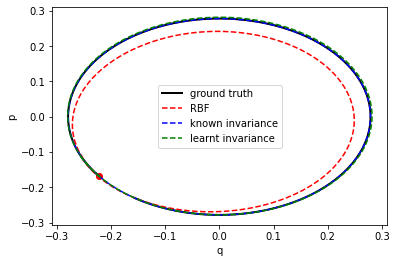

In [29]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots()
plt.plot(evaluate_moi[4][:,0],evaluate_moi[4][:,1], label="ground truth", color="black", linewidth=2)
plt.plot(evaluate_moi[1][:,0],evaluate_moi[1][:,1], "--", label='RBF', color="red")
plt.plot(evaluate_invariance[1][:,0],evaluate_invariance[1][:,1], "--", label="known invariance", color="blue")
plt.plot(evaluate_invariance_p[1][:,0],evaluate_invariance_p[1][:,1], "--", label="learnt invariance", color="green")
plt.scatter(evaluate_moi[4][0,0],evaluate_moi[4][0,1],color="red")
plt.xlabel("q")
plt.ylabel("p")
plt.legend()
#plt.savefig("figures/parameterised_pendulum_predicted_trajectory.pdf")

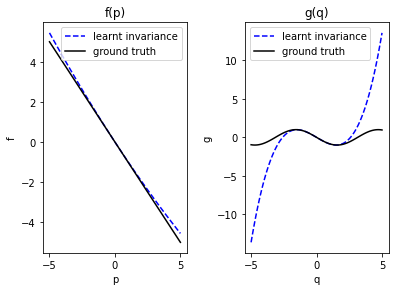

In [23]:
from numpy.polynomial import polynomial
x = np.linspace(-5,5,100)
multiplier = -m.kernel.f_poly.numpy()[1]
f = polynomial.Polynomial(np.squeeze(kernel.f_poly.numpy()))
g = polynomial.Polynomial(np.squeeze(kernel.g_poly.numpy()))

fig, (ax1, ax2) = plt.subplots(1, 2)
ax1.plot(x, f(x)/multiplier, "--", color="blue", label='learnt invariance')
ax1.plot(x, -x, label='ground truth', color="black")
ax1.set_title("f(p)")
ax1.set_xlabel("p")
ax1.set_ylabel("f")
ax1.legend()
ax2.set_title("g(q)")
ax2.plot(x, g(x)/multiplier, "--", color="blue",label='learnt invariance')
ax2.plot(x, -np.sin(x), color="black", label='ground truth')
ax2.legend()
ax2.set_xlabel("q")
ax2.set_ylabel("g")
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=0.9, 
                    top=0.9, 
                    wspace=0.4, 
                    hspace=0.4)
plt.savefig("figures/parameterised_pendulum_learnt_polynomial.pdf")

